In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow.keras.backend as K
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, lars_path
from sklearn.utils.extmath import randomized_svd
from scipy import linalg
from joblib import Parallel, delayed
import itertools
import numpy as np
import pandas as pd
import random
import time
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.style.use('seaborn-v0_8-paper')

2024-03-29 21:40:09.374249: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-29 21:40:09.397294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 21:40:09.397316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 21:40:09.397985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 21:40:09.402184: I tensorflow/core/platform/cpu_feature_guar

## Preparing Data

In [2]:
# Reading the CSV file into a pandas DataFrame
# Replace "/mnt/storage/dissertacao/maryland/db_maryland_escolhido/cell-001/continuous_cycle/cell-001_continuous_cycle_merged.csv"
# with the appropriate path to your CSV file
X = pd.read_csv("cell-001_continuous_cycle_merged.csv")

# Filling missing values in the DataFrame with 0
X = X.fillna(0)

# Dropping columns from the DataFrame that doesnt bring relevant information to the analysis 
# These columns might not be needed for further analysis
X = X.drop(['Date_Time','Step_Time(s)', 'Step_Index','celula',"Unnamed: 0.1","Unnamed: 0",'ACR(Ohm)','Internal Resistance(Ohm)'], axis=1)

# Displaying the first few rows of the DataFrame to check the changes
X.head(10)

,Test_Time(s),Cycle_Index,Voltage(V),Current(A),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),temperatura,dV/dt(V/s)
0,120.0002,1,3.409640,0.0,0.0,0.0,0.0,0.0,10,0.0
1,240.0001,1,3.410280,0.0,0.0,0.0,0.0,0.0,10,0.0
2,360.0003,1,3.410618,0.0,0.0,0.0,0.0,0.0,10,0.0
3,480.0005,1,3.410776,0.0,0.0,0.0,0.0,0.0,10,0.0
4,600.0005,1,3.410976,0.0,0.0,0.0,0.0,0.0,10,0.0
5,720.0013,1,3.411161,0.0,0.0,0.0,0.0,0.0,10,0.0
6,840.0005,1,3.411312,0.0,0.0,0.0,0.0,0.0,10,0.0
7,960.0016,1,3.411501,0.0,0.0,0.0,0.0,0.0,10,0.0
8,1080.0010,1,3.411621,0.0,0.0,0.0,0.0,0.0,10,0.0
9,1200.0002,1,3.411757,0.0,0.0,0.0,0.0,0.0,10,0.0


In [3]:
# Verifying columns variables, non-null values and dataframe size
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48993 entries, 0 to 48992
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Test_Time(s)            48993 non-null  float64
 1   Cycle_Index             48993 non-null  int64  
 2   Voltage(V)              48993 non-null  float64
 3   Current(A)              48993 non-null  float64
 4   Charge_Capacity(Ah)     48993 non-null  float64
 5   Discharge_Capacity(Ah)  48993 non-null  float64
 6   Charge_Energy(Wh)       48993 non-null  float64
 7   Discharge_Energy(Wh)    48993 non-null  float64
 8   temperatura             48993 non-null  int64  
 9   dV/dt(V/s)              48993 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 3.7 MB


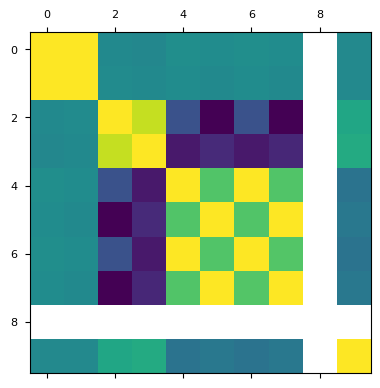

In [4]:
#Checking correlation between dataframe variables
plt.matshow(X.corr())

In [5]:
#Training the scaler for this data and applying it on the data matrix to run PCA
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X)
X1 = scaler.transform(X)

## Classic PCA

In [6]:
def pca_projection(X, variance_ratio_threshold):
    # Subtract mean from the data
    X = X - X.mean()
    
    # Calculate covariance matrix
    S_x = np.cov(X.T)
    
    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(S_x)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Compute explained variance ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    
    # Determine how many principal components to keep
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    num_components = np.argmax(cumulative_variance_ratio >= variance_ratio_threshold) + 1
    
    # Project the data onto the selected principal components
    Z = X @ eigenvectors[:, :num_components]
    
    # Reconstruct the original data
    X_reconstructed = Z @ eigenvectors[:, :num_components].T
    
    return Z, X_reconstructed, num_components, explained_variance_ratio[:num_components], eigenvectors[:, :num_components]

# Example usage:
# Assuming X is your data matrix
projected_data, reconstructed_data, num_components, explained_variance_ratios,eigv = pca_projection(X1,variance_ratio_threshold=1)
print("Number of principal components:", num_components)
print("Explained variance ratios:", explained_variance_ratios)

Number of principal components: 9
Explained variance ratios: [5.87958043e-01 2.32550690e-01 1.31160755e-01 4.38726265e-02
 3.72070060e-03 6.93104004e-04 2.76313536e-05 1.43569169e-05
 2.09321069e-06]


Text(0.5, 0, 'Components')

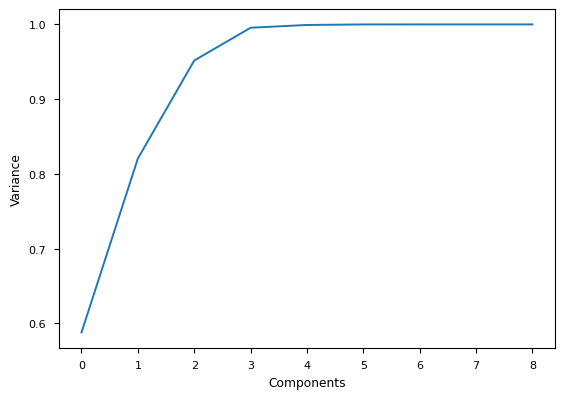

In [7]:
plt.plot(np.cumsum(explained_variance_ratios))
plt.ylabel('Variance')
plt.xlabel('Components')

In [8]:
for i in range(eigv.shape[1]):
    for j in range(eigv.shape[1]):
        if(np.dot(eigv[:,i],eigv[:,j]) <1e-9):
            #dot product between an eigenvector and the others
            print(0)
        else:
            #dot product between an eigenvector against itself
            print(np.dot(eigv[:,i],eigv[:,j]))

1.0000000000000002
0
0
0
0
0
0
0
0
0
1.0
0
0
0
0
0
0
0
0
0
1.0
0
0
0
0
0
0
0
0
0
0.9999999999999999
0
0
0
0
0
0
0
0
0
1.0
0
0
0
0
0
0
0
0
0
0.9999999999999999
0
0
0
0
0
0
0
0
0
1.0
0
0
0
0
0
0
0
0
0
1.0000000000000002
0
0
0
0
0
0
0
0
0
1.0


## Scikit learn PCA Implementation

In [9]:
# sklearn's PCA for comparison
pca = PCA(n_components=9, svd_solver='randomized')
pca.fit(X1)
eigv_sk_pca = pca.components_.T
sk_variance_pca = pca.explained_variance_

Text(0.5, 0, 'Components')

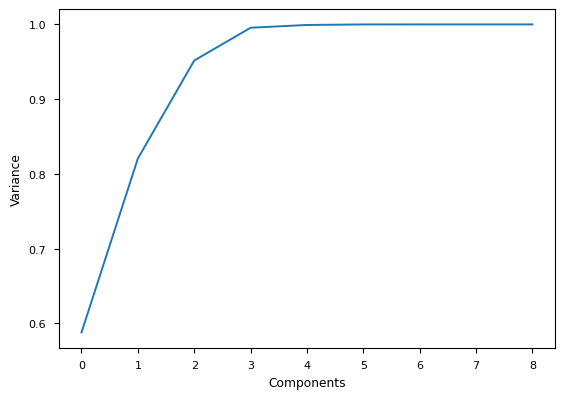

In [10]:
plt.plot(np.cumsum(pca.explained_variance_/np.sum(pca.explained_variance_)))
plt.ylabel('Variance')
plt.xlabel('Components')

## Checking if eigenvectors spanned are Linearly independent 

In [11]:
for i in range(eigv_sk_pca.shape[1]):
    for j in range(eigv_sk_pca.shape[1]):
        if(np.dot(eigv_sk_pca[:,i],eigv_sk_pca[:,j]) <1e-9):
            #dot product between an eigenvector and the others
            print(0)
        else:
            #dot product between an eigenvector against itself
            print(np.dot(eigv_sk_pca[:,i],eigv_sk_pca[:,j]))

1.0
0
0
0
0
0
0
0
0
0
1.0000000000000009
0
0
0
0
0
0
0
0
0
1.0000000000000004
0
0
0
0
0
0
0
0
0
0.9999999999999994
0
0
0
0
0
0
0
0
0
0.9999999999999988
0
0
0
0
0
0
0
0
0
0.9999999999999984
0
0
0
0
0
0
0
0
0
0.9999999999999997
0
0
0
0
0
0
0
0
0
0.9999999999999996
0
0
0
0
0
0
0
0
0
1.0000000000000004


## Checking if eigenvectors spanned are Linearly independent between from scratch Implementation and scikit-learn implementation

In [12]:
for i in range(eigv_sk_pca.shape[1]):
    for j in range(eigv_sk_pca.shape[1]):
        if(np.dot(eigv[:,i],eigv_sk_pca[:,j]) <1e-9):
            #dot product between an eigenvector and the others
            print(0)
        else:
            #dot product between an eigenvector against itself
            print(np.dot(eigv[:,i],eigv_sk_pca[:,j]))

1.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1.0000000000000004
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.9999999999999994
0
0
0
0
0
0
0
0
0
0.9999999999999992
0
0
0
0
0
0
0
0
0
0.9999999999999999
0
0
0
0
0
0
0
0
0
0.9999999999999999
0
0
0
0
0
0
0
0
0
0


## PCA using SVD 

In [13]:
def pca_svd(X, n_components=None):
    """
    Perform PCA using Singular Value Decomposition (SVD).

    Parameters:
    X : array-like, shape (n_samples, n_features)
        The input data.
    n_components : int or None, optional (default=None)
        Number of components to keep. If None, all components are kept.

    Returns:
    X_pca : array-like, shape (n_samples, n_components)
        The transformed data.
    explained_variance : array, shape (n_components,)
        The explained variance of each principal component.
    """
    # Perform Singular Value Decomposition (SVD)
    u, s, v = np.linalg.svd(X, full_matrices=False)
    
    # Determine the number of components to keep
    if n_components is None:
        n_components = min(X.shape)
    
    # Select the top n_components
    v_selected = v[:n_components]
    
    # Compute transformed data
    X_pca = X @ v_selected.T
    
    # Compute explained variance
    explained_variance = (s**2) / (len(X) - 1)
    
    return v_selected, explained_variance[:n_components]

In [14]:
# Choose the number of components to extract
n_components = 9

eig_V, explained_variance = pca_svd(X1, n_components=n_components)

Text(0.5, 0, 'Components')

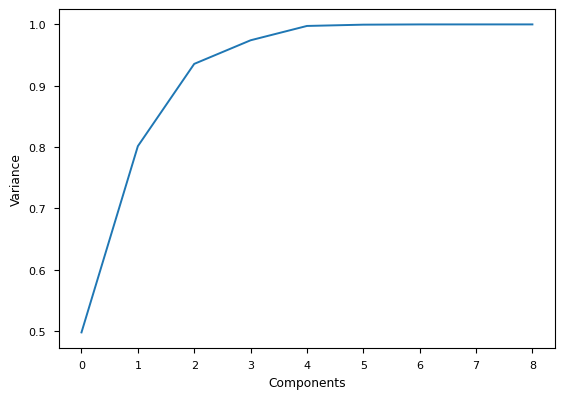

In [15]:
plt.plot(np.cumsum(explained_variance/np.sum(explained_variance)))
plt.ylabel('Variance')
plt.xlabel('Components')

In [16]:
for i in range(eig_V.shape[1]):
    for j in range(eig_V.shape[1]):
        if(np.dot(eig_V[:,i],eig_V[:,j].T) <1e-9):
            #dot product between an eigenvector and the others
            print(0)
        else:
            #dot product between an eigenvector against itself
            print(np.dot(eig_V[:,i],eig_V[:,j].T))

0.9630371323127462
0.03591600185150404
0.001595273741727971
0
0.12950809540656422
0.018701584184019043
0
0
0.000524875577477598
0
0.03591600185150404
0.9651012145509981
0
0.0026949076678249757
0
0
0.12616857734462872
0.01721809020376236
0
0.00019988916787021553
0.001595273741727971
0
0.9999311498682248
0.00011969916519805057
0
0
0.005604004011951113
0.0007647724069715367
0
8.87843647175146e-06
0
0.0026949076678249757
0.00011969916519805057
0.9997918974186439
0.009717461336580996
0.0014032475782348175
0
0
3.9383315109386974e-05
0
0.12950809540656422
0
0
0.009717461336580996
0.5462379456662141
0
0.4549462999700268
0.06208603279527532
0
0.0007207724715659822
0.018701584184019043
0
0
0.0014032475782348175
0
0.9905378215253424
0.0656964068646643
0.00896551806531859
0
0.00010408296880744933
0
0.12616857734462872
0.005604004011951113
0
0.4549462999700268
0.0656964068646643
0.5438663637039888
0
0.0018438245205324166
0
0
0.01721809020376236
0.0007647724069715367
0
0.06208603279527532
0.00896551

## PCA using SVD randomized

In [17]:
import numpy as np
from sklearn.utils.extmath import randomized_svd

def pca_randomized_svd(X, n_components=None):
    """
    Perform PCA using randomized Singular Value Decomposition (SVD).

    Parameters:
    X : array-like, shape (n_samples, n_features)
        The input data.
    n_components : int or None, optional (default=None)
        Number of components to keep. If None, all components are kept.

    Returns:
    X_pca : array-like, shape (n_samples, n_components)
        The transformed data.
    explained_variance : array, shape (n_components,)
        The explained variance of each principal component.
    """
    # Determine the number of components to keep
    if n_components is None:
        n_components = min(X.shape)
    
    # Perform randomized Singular Value Decomposition (SVD)
    U, S, VT = randomized_svd(X, n_components)
    
    # Select the top n_components
    VT_selected = VT[:n_components]
    
    # Compute transformed data
    X_pca = X @ VT_selected.T
    
    # Compute explained variance
    explained_variance = (S**2) / (len(X) - 1)
    
    return VT_selected, explained_variance

In [18]:
# Choose the number of components to extract
n_components = 9

VT, explained_variance = pca_randomized_svd(X1, n_components=n_components)

Text(0.5, 0, 'Components')

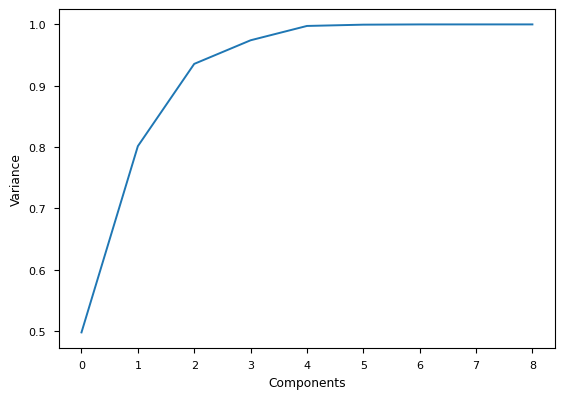

In [19]:
plt.plot(np.cumsum(explained_variance/np.sum(explained_variance)))
plt.ylabel('Variance')
plt.xlabel('Components')

In [20]:
for i in range(VT.shape[1]):
    for j in range(VT.shape[1]):
        if(np.dot(VT[:,i],VT[:,j].T) <1e-9):
            #dot product between an eigenvector and the others
            print(0)
        else:
            #dot product between an eigenvector against itself
            print(np.dot(VT[:,i],VT[:,j].T))

0.9630371323127435
0.03591600185150717
0.0015952737417278748
0
0.12950809540656838
0.018701584184020903
0
0
0.0005248755774775954
0
0.03591600185150717
0.9651012145509954
0
0.002694907667824955
0
0
0.12616857734463274
0.01721809020376419
0
0.00019988916787018647
0.0015952737417278748
0
0.9999311498682248
0.00011969916519790702
0
0
0.005604004011950725
0.0007647724069710683
0
8.878436471769838e-06
0
0.002694907667824955
0.00011969916519790702
0.9997918974186442
0.009717461336580862
0.0014032475782345226
0
0
3.938331510996198e-05
0
0.12950809540656838
0
0
0.009717461336580862
0.546237945666218
0
0.454946299970023
0.06208603279527985
0
0.0007207724715657736
0.018701584184020903
0
0
0.0014032475782345226
0
0.9905378215253405
0.06569640686466836
0.008965518065320872
0
0.00010408296880739338
0
0.12616857734463274
0.005604004011950725
0
0.454946299970023
0.06569640686466836
0.5438663637039934
0
0.0018438245205325376
0
0
0.01721809020376419
0.0007647724069710683
0
0.06208603279527985
0.0089655

## Issues Requiring Debugging in Codes

The following codes exhibit various issues and function only partially:

- **PCA via Vanilla Autoencoder:** The process of ensuring linear independence between components encounters challenges in properly projecting both the input data and weight vectors onto the subspace spanned by previously obtained components.

- **Incremental PCA:** Challenges arise from the row-by-row update approach, leading to discrepancies in the intended PCA transformations.

- **Sparse PCA:** Optimization likely requires the utilization of dedicated solvers such as Gurobi or optimization libraries like those found in SciPy.

These identified issues necessitate resolution for the successful functioning of these implementations.

## PCA through vanilla autoencoder

In [21]:
# Function to build the autoencoder model
def build_autoencoder_model(data_matrix, initial_weight_matrix):
    """
    Build an autoencoder model based on the dimensions of the input data matrix.

    Parameters:
    data_matrix : array-like
        Input data matrix.
    hidden_units : int
        Number of neurons in the hidden layer.

    Returns:
    model_autoencoder : Sequential
        Constructed autoencoder model.
    """
    # Get input shape from data matrix
    input_shape = data_matrix.shape[1:]

    # Create the autoencoder model
    model_autoencoder = Sequential()

    # Flatten the input data
    model_autoencoder.add(Flatten(input_shape=input_shape))

    # Encoder
    model_autoencoder.add(Dense(hidden_units, activation='linear', weights=initial_weight_matrix))

    # Decoder
    model_autoencoder.add(Dense(input_shape[0], activation='linear'))

    # Compile the model
    model_autoencoder.compile(loss=MeanAbsoluteError(), optimizer=Adam(), metrics=[RootMeanSquaredError()])

    # Build the model
    model_autoencoder.build(input_shape=input_shape)

    # Display the model summary
    model_autoencoder.summary()

    return model_autoencoder

In [22]:
# Initialize variables
num_components = X1.shape[1]
iter = 1
hidden_units = 1
j = 0
pesos = []
X = []

#Attempt to train each neuron as one component linearly independent from the others
while iter =< num_components:
    print(iter)
    #First component NN train
    if iter == 1:
        data_matrix = X1 
        initial_weight_matrix = [np.random.rand(data_matrix.shape[1], hidden_units), np.random.rand(hidden_units)]  
        pesos.append(initial_weight_matrix[0])
    #From the second component till desired number of components it will compute this loop
    else:
        correction_matrix = np.zeros_like(data_matrix)  # Initialize correction matrix
        #try to calculate a correction matrix that is the matrix projected 
        #in the vector space of the last iteration weight vectors obtained
        for i in range(len(pesos)):
            dot_product = np.dot(data_matrix, pesos[i])
            matrix_norm_squared = np.dot(pesos[i].T, pesos[i])
            correction_matrix += np.dot(data_matrix.T, dot_product) / matrix_norm_squared
        data_matrix = data_matrix - correction_matrix
        X.append(data_matrix)
        #try to calculate a correction matrix that for the weight initialization of the current iteration projected 
        #in the vector space of the last iteration weight vectors obtained
        initial_weight_ = [np.random.rand(data_matrix.shape[1], hidden_units), np.random.rand(hidden_units)]
        for i in range(len(pesos)):
            dot_product = np.dot(pesos[i], pesos[i].T)
            matrix_norm_squared = np.dot(pesos[i].T, pesos[i])
            correction_matrix += np.dot(initial_weight_[0].T, dot_product) / matrix_norm_squared
        initial_weight_matrix = initial_weight_[0] - correction_matrix
        pesos.append(initial_weight_matrix)
        #Array where the first element are the weight vector and the second elemetn is the neuron bias
        initial_weight_matrix = [initial_weight_matrix, np.random.rand(hidden_units)]
    
    # Build the autoencoder model
    model = build_autoencoder_model(data_matrix, initial_weight_matrix)
    
    # Fit the model
    model.fit(data_matrix, data_matrix, epochs=10, batch_size=50)
    
    # Retrieve the weight vector from the encoder
    layer_index = 1  
    weights = model.layers[layer_index].get_weights()
    weights_matrix = weights[0]
    print(weights_matrix)

    # Now weights is a list containing the weights and biases of the layer
    pesos.append(weights_matrix) 
    
    iter += 1

# Print final weights
print("Final weights:", weights_matrix)

1


2024-03-29 21:40:11.810412: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-29 21:40:11.814112: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-29 21:40:11.814139: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-29 21:40:11.816127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-29 21:40:11.816154: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
 dense_1 (Dense)             (None, 10)                20        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-29 21:40:11.902810: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-29 21:40:11.902849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-29 21:40:11.902855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-03-29 21:40:11.902873: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000

Epoch 1/10
  1/980 [..............................] - ETA: 10:31 - loss: 0.6078 - root_mean_squared_error: 0.7063

2024-03-29 21:40:12.852415: I external/local_xla/xla/service/service.cc:168] XLA service 0xb979130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-29 21:40:12.852445: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-29 21:40:12.856090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-29 21:40:12.868685: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1711748412.909334    6792 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


980/980 [==============================] - 3s 2ms/step - loss: 0.3545 - root_mean_squared_error: 0.4851
Epoch 2/10
980/980 [==============================] - 2s 2ms/step - loss: 0.2247 - root_mean_squared_error: 0.3642
Epoch 3/10
980/980 [==============================] - 2s 2ms/step - loss: 0.2218 - root_mean_squared_error: 0.3617
Epoch 4/10
980/980 [==============================] - 3s 3ms/step - loss: 0.2212 - root_mean_squared_error: 0.3619
Epoch 5/10
980/980 [==============================] - 3s 3ms/step - loss: 0.2209 - root_mean_squared_error: 0.3630
Epoch 6/10
980/980 [==============================] - 2s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.3641
Epoch 7/10
980/980 [==============================] - 2s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.3652
Epoch 8/10
980/980 [==============================] - 3s 3ms/step - loss: 0.2208 - root_mean_squared_error: 0.3661
Epoch 9/10
980/980 [==============================] - 3s 3ms/step - loss: 0.2207 - root_mea

ValueError: shapes (10,1) and (10,1) not aligned: 1 (dim 1) != 10 (dim 0)

In [23]:
for i in range(len(weights_matrix)):
    for j in range(len(weights_matrix)):
        if(np.dot(weights_matrix[i],weights_matrix[j].T) <1e-9):
            #dot product between an eigenvector and the others
            print(0)
        else:
            #dot product between an eigenvector against itself
            print(np.dot(weights_matrix[i],weights_matrix[j].T))

ValueError: operands could not be broadcast together with shapes (48993,10) (10,1) 

## Incremental PCA

In [ ]:
#!/usr/bin/env python

"""
Incremental PCA calculation module.

Based on P.Hall, D. Marshall and R. Martin "Incremental Eigenalysis for
Classification" which appeared in British Machine Vision Conference, volume 1,
pages 286-295, September 1998.

Principal components are updated sequentially as new observations are
introduced. Each new observation (x) is projected on the eigenspace spanned by
the current principal components (U) and the residual vector (r = x - U(U.T*x))
is used as a new principal component (U' = [U r]). The new principal components
are then rotated by a rotation matrix (R) whose columns are the eigenvectors
of the transformed covariance matrix (D=U'.T*C*U) to yield p + 1 principal
components. From those, only the first p are selected.

"""
_ZERO_THRESHOLD = 1e-9      # Everything below this is zero

class IPCA(object):
    """Incremental PCA calculation object.

    General Parameters:
        m - Number of variables per observation
        n - Number of observations
        p - Dimension to which the data should be reduced
    """

    def __init__(self, m, p):
        """Creates an incremental PCA object for m-dimensional observations
        in order to reduce them to a p-dimensional subspace.

        @param m: Number of variables per observation.
        @param p: Number of principle components.

        @return: An IPCA object.
        """
        self._m = float(m)
        self._n = 0.0
        self._p = int(p)
        self._mean = np.zeros((m , 1), dtype=np.float64)
        self._covariance = np.zeros((m, m), dtype=np.float64)
        self._eigenvectors = np.zeros((m, p), dtype=np.float64)
        self._eigenvalues = np.zeros((1, p), dtype=np.float64)

    def update(self, x):
        """Updates with a new observation vector x.

        @param x: Next observation as a column vector (m x 1).
        """
        m = self._m
        n = self._n
        p = self._p
        mean = self._mean
        C = self._covariance
        U = self._eigenvectors
        E = self._eigenvalues

        if type(x) is not np.ndarray or x.shape != (m, 1):
            raise TypeError('Input is not a matrix (%d, 1)' % int(m))

        # Update covariance matrix and mean vector and centralize input around
        # new mean
        oldmean = mean
        mean = (n*mean + x) / (n + 1.0)
        C = (n*C + x@x.T + n*oldmean@oldmean.T - (n+1)*mean@mean.T) / (n + 1.0)
        x -= mean

        # Project new input on current p-dimensional subspace and calculate
        # the normalized residual vector
        g = U.T@x
        r = x - (U@g)
        r = (r / np.linalg.norm(r)) if not _is_zero(r) else np.zeros_like(r)

        # Extend the transformation matrix with the residual vector and find
        # the rotation matrix by solving the eigenproblem DR=RE
        U = np.concatenate((U, r), 1)
        D = U.T@C@U
        (E, R) = np.linalg.eigh(D)

        # Sort eigenvalues and eigenvectors from largest to smallest to get the
        # rotation matrix R
        sorter = list(reversed(E.argsort(0)))
        E = E[sorter]
        R = R[:,sorter]

        # Apply the rotation matrix
        U = U@R

        # Select only p largest eigenvectors and values and update state
        self._n += 1.0
        self._mean = mean
        self._covariance = C
        self._eigenvectors = U[:, :p]
        self._eigenvalues = E[:p]

    @property
    def components(self):
        """Returns a matrix with the current principal components as columns.
        """
        return self._eigenvectors

    @property
    def variances(self):
        """Returns a list with the appropriate variance along each principal
        component.
        """
        return self._eigenvalues

def _is_zero(x):
    """Return a boolean indicating whether the given vector is a zero vector up
    to a threshold.
    """
    return np.fabs(x).min() < _ZERO_THRESHOLD

In [ ]:
pca = IPCA(X1.shape[1], 3)
for i in range(X1.shape[0]):
    x = X1[i,:].reshape(-1, 1)  # Accessing each row as a column vector
    pca.update(x)
U = pca.components
V = pca.variances
print(U)
print(V)

### Sparse PCA

In [ ]:
################################################################################
# Utilities to spread load on CPUs
def _gen_even_slices(n, n_packs):
    """Generator to create n_packs slices going up to n."""
    start = 0
    for pack_num in range(n_packs):
        this_n = n // n_packs
        if pack_num < n % n_packs:
            this_n += 1
        if this_n > 0:
            end = start + this_n
            yield slice(start, end, None)
            start = end

def cpu_count():
    """Return the number of CPUs."""
    try:
        import multiprocessing
        return multiprocessing.cpu_count()
    except ImportError:
        return 1

################################################################################
# Sparse PCA
def _update_V(U, Y, V, alpha, Gram=None, method='lars'):
    """Update V in sparse PCA loop."""
    coef = np.empty_like(V)
    if method == 'lars':
        n_samples = U.shape[0]
        alpha = alpha * n_samples
        XY = np.dot(U.T, Y)
        for k in range(V.shape[1]):
            _, _, coef_path_ = lars_path(U, Y[:, k], Xy=XY[:, k], Gram=Gram,
                                         alpha_min=alpha, method='lasso')
            coef[:, k] = coef_path_[:, -1]
    else:
        clf = Lasso(alpha=alpha, fit_intercept=False)
        for k in range(V.shape[1]):
            clf.coef_ = V[:, k]  # Initialize with previous value of Vk
            clf.fit(U, Y[:, k], max_iter=1000, tol=1e-8)
            coef[:, k] = clf.coef_
    return coef

def _update_U(U, Y, V, verbose=False, return_r2=False):
    """Update U in sparse PCA loop. This function modifies U in-place."""
    n_atoms = len(V)
    n_samples = Y.shape[0]
    R = -np.dot(U, V)  # Residuals, computed in-place for efficiency
    R += Y
    R = np.asfortranarray(R)
    ger, = linalg.get_blas_funcs(('ger',), (U, V))
    for k in range(n_atoms):
        R = ger(1.0, U[:, k], V[k, :], a=R, overwrite_a=True)
        U[:, k] = np.dot(R, V[k, :].T)
        # Scale Uk
        if (U[:, k] ** 2).sum() < 1e-20:
            U[:, k] = np.random.randn(n_samples)  # Add new random atom
            V[k, :] = 0.0  # Setting corresponding coefficients to 0
            U[:, k] /= linalg.norm(U[:, k])
        else:
            U[:, k] /= linalg.norm(U[:, k])
            R = ger(-1.0, U[:, k], V[k, :], a=R, overwrite_a=True)
    if return_r2:
        R **= 2
        R = np.sum(R)
        return U, R
    return U

def sparse_pca(Y, n_atoms, alpha, maxit=100, tol=1e-8, method='lars',
               n_jobs=1, U_init=None, V_init=None, callback=None, verbose=False):
    """
    Compute sparse PCA with n_atoms components
    (U^*,V^*) = argmin 0.5 || Y - U V ||_2^2 + alpha * || V ||_1
                 (U,V)
                with || U_k ||_2 = 1 for all  0<= k < n_atoms
    """
    t0 = time.time()
    n_samples = Y.shape[0]
    alpha = float(alpha)  # Avoid integer division problems

    if n_jobs == -1:
        n_jobs = cpu_count()

    # Initialize U and V with SVD of Y
    if U_init is not None and V_init is not None:
        U = np.asarray(U_init).copy()
        V = np.asarray(V_init).copy()
    else:
        U, S, V = linalg.svd(Y, full_matrices=False)
        V = S[:, np.newaxis] * V
    U = U[:, :n_atoms]
    V = V[:n_atoms, :]

    def cost_function():
        return 0.5 * np.sum((Y - np.dot(U, V))**2) \
            + alpha * np.sum(np.abs(V))

    E = []
    current_cost = np.nan

    for ii in range(maxit):
        dt = (time.time() - t0)
        if verbose:
            sys.stdout.write(".")
            sys.stdout.flush()
            if verbose > 1:
                print("Iteration % 3i "
                      "(elapsed time: % 3is, % 4.1fmn, current cost % 7.3f)" %
                      (ii, dt, dt / 60, current_cost))

        # Update V
        Gram = np.dot(U.T, U)
        slices = list(_gen_even_slices(V.shape[1], n_jobs))
        V_views = Parallel(n_jobs=n_jobs)(delayed(_update_V)(U, Y[:, this_slice], V[:, this_slice].copy(),
                       alpha=alpha / n_samples,
                       Gram=Gram, method=method)
                       for this_slice in slices)

        # Collect the modified views of V
        modified_views = [view for view in V_views]

        # Update the original V matrix with the modified views
        for this_slice, modified_view in zip(slices, modified_views):
            V[:, this_slice] = modified_view


        # Update U
        U = _update_U(U, Y, V, verbose=verbose)

        current_cost = cost_function()
        E.append(current_cost)

        if ii > 0:
            dE = E[-2] - E[-1]
            assert(dE >= 0)
            if dE < tol * E[-1]:
                if verbose:
                    print("Convergence reached after %d iterations" % ii)
                break
        if ii % 5 == 0 and callback is not None:
            callback(locals())
    return U, V, E

In [ ]:
# Define parameters
n_atoms = 3  # Number of atoms
alpha = 0.5  # Regularization parameter

# Call the sparse PCA function
U_estimated, V_estimated, E = sparse_pca(X1, n_atoms, alpha, maxit=100, method='lars', n_jobs=1, verbose=2)

In [ ]:
U_estimated